In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel, TwoModels, ClassTransformation
from catboost import CatBoostClassifier

In [2]:
df = pd.read_csv('data.csv')

### Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие. Cделать разбиение набора данных на тренировочную и тестовую выборки

In [3]:
df.rename(columns={'conversion':'target', 
                   'offer':'treatment'}, inplace=True)

In [4]:
df

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,Discount,0
63996,5,38.91,0,1,Urban,1,Phone,Discount,0
63997,6,29.99,1,0,Urban,1,Phone,Discount,0
63998,1,552.94,1,0,Surburban,1,Multichannel,Buy One Get One,0


In [5]:
df['treatment'] = df['treatment'].apply(lambda x: 0 if x=='No Offer' else 1)

In [6]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.column]

In [7]:
pipe = Pipeline([
    ('feat_select', FeatureSelector(['recency', 'history'])),
    ('scaler', MinMaxScaler())
])

In [8]:
df[['recency', 'history']] = pipe.fit_transform(df)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'])

In [10]:
treat_train = X_train['treatment']
treat_test = X_test['treatment']
for i in [X_train, X_test]:
    i.drop('treatment', axis=1, inplace=True)

In [11]:
catb_params = {
    'iterations':100, 'cat_features': ['used_discount', 'zip_code', 'is_referral', 
                                                                'channel'], 
    'random_state':42, 'silent':True
}

In [12]:
sm = SoloModel(CatBoostClassifier(**catb_params))
sm.fit(X_train, y_train, treat_train)

SoloModel(estimator=<catboost.core.CatBoostClassifier object at 0x7fe8c66d5be0>)

In [13]:
pred = sm.predict(X_test)

In [14]:
result = pd.DataFrame(columns=['model', 'uplift 10%', 'uplift 20%'])

In [15]:
score10 = uplift_at_k(y_true=y_test, uplift=pred, treatment=treat_test, strategy='by_group', k=0.1)
score20 = uplift_at_k(y_true=y_test, uplift=pred, treatment=treat_test, strategy='by_group', k=0.2)

In [16]:
result = result.append({'model': 'solo_model', 'uplift 10%': score10, 'uplift 20%': score20}, ignore_index=True)

In [17]:
ct = ClassTransformation(CatBoostClassifier(**catb_params))
ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_test)

score10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
score20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)

result = result.append({'model': 'class_transform', 'uplift 10%': score10, 'uplift 20%': score20}, ignore_index=True)

<ipython-input-17-20f52292e30c>:2: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  ct.fit(X_train, y_train, treat_train)


In [18]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(**catb_params), 
    estimator_ctrl=CatBoostClassifier(**catb_params), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
)

uplift_tm = tm.predict(X_test)

score10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
score20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)
result = result.append({'model': 'two_models', 'uplift 10%': score10, 'uplift 20%': score20}, ignore_index=True)

In [19]:
result

,model,uplift 10%,uplift 20%
0,solo_model,0.077898,0.070928
1,class_transform,0.116834,0.100479
2,two_models,0.106385,0.092041


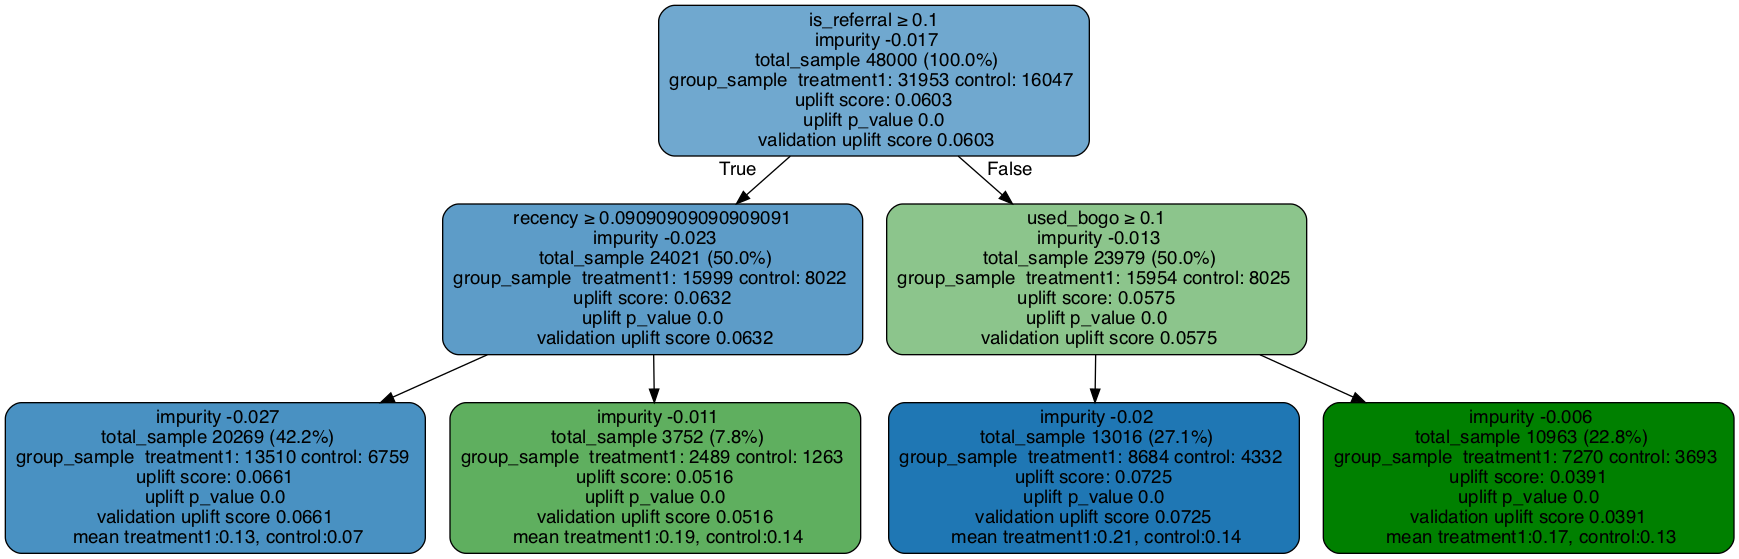

In [24]:
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

features = X_train.columns.to_list()

uplift_model = UpliftTreeClassifier(max_depth=3, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)

Image(graph.create_png())

### Специально сделал небольшую глубину. Видно, что дерево строится таким образом, что первое разбиение выбирается по тому, участвует ли клиент в реферальной программе, на втором уровне разбиения по давности последней покупки и по тому, пользовался ли он акцией ранее. Таким образом, объекты разделяются на 4 листа, для каждого из которых подсчитан аплифт, наибольший он в том случае, если клиент не пользуется реферальной программой и пользовался акцией, а наименьший у тех, кто не пользуется реферальной программой и не пользовался акцией